In [1]:
import numpy as np
import cv2
import pandas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
# import tensorflow_datasets as tfds


In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D,  Activation, SpatialDropout2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'TrialData', color_mode='grayscale',  image_size=(128, 67), shuffle=True, seed=123, batch_size = 64
)


Found 6332 files belonging to 2 classes.


In [5]:
numpy_images = []
numpy_labels = []

In [6]:
for i in range(len(train_ds)):
    print(i)
    for images, labels in train_ds.take(i):  
        numpy_images.extend(images)
        numpy_labels.extend(labels)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


In [7]:
numimages = np.asarray(numpy_images, dtype ='uint8')
numlabels = np.asarray(numpy_labels, dtype='uint8')

In [8]:
print(len(numpy_images))
print(numimages.shape)
print(len(numpy_labels))
print(numlabels.shape)


310464
(310464, 128, 67, 1)
310464
(310464,)


In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


Using TensorFlow backend.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(numimages, numlabels, test_size = .2, random_state = 42)
del numimages
del numlabels
del numpy_images
del numpy_labels

In [11]:
X_train = X_train.astype('float32') 


In [12]:
X_test = X_test.astype('float32')

In [13]:
y_train = y_train.astype('float32')

In [14]:
y_test = y_test.astype('float32')

In [15]:
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)

In [16]:
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (248371, 128, 67, 1)
y_train shape :  (248371, 2)
X_test shape :  (62093, 128, 67, 1)
y_test shape :  (62093,)


In [22]:

class_names = train_ds.class_names
print(class_names)

['Elephant', 'Non']


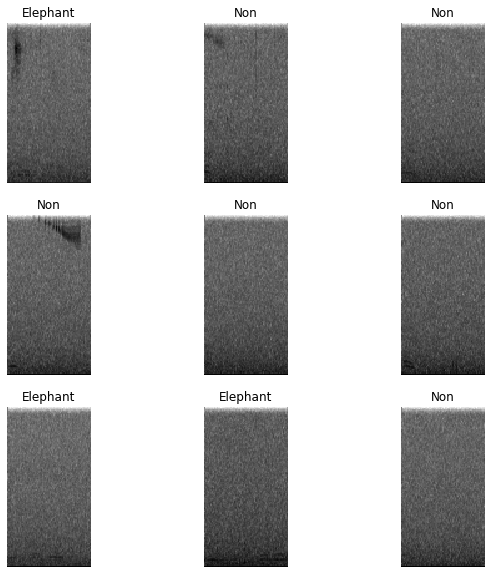

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.reshape(images[i], (128, 67)), cmap=plt.get_cmap('gray'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
X_train[1]

array([[[123.],
        [229.],
        [236.],
        ...,
        [222.],
        [231.],
        [222.]],

       [[122.],
        [200.],
        [193.],
        ...,
        [190.],
        [187.],
        [195.]],

       [[120.],
        [155.],
        [151.],
        ...,
        [161.],
        [162.],
        [138.]],

       ...,

       [[ 62.],
        [ 42.],
        [ 24.],
        ...,
        [ 31.],
        [ 55.],
        [ 31.]],

       [[ 39.],
        [ 45.],
        [ 36.],
        ...,
        [ 31.],
        [ 48.],
        [ 32.]],

       [[ 10.],
        [ 11.],
        [  7.],
        ...,
        [ 11.],
        [ 10.],
        [  7.]]], dtype=float32)

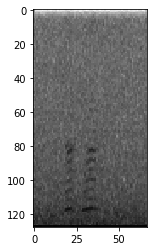

In [13]:
plt.imshow(np.reshape(images[1], (128, 67)), cmap=plt.get_cmap('gray'), vmin = 0, vmax = 255)

In [17]:


def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters



def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(128, 67, 1))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [18]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 2
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)

model.summary()


# training
epochs = 30
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 67, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 67, 24)  216         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 67, 24)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 34, 24)   0           activation[0][0]                 
______________________________________________________________________________________________

In [19]:
model.fit(X_train,y_train, epochs=3,validation_data=(X_test, Cat_test_y), batch_size = 32)

Epoch 1/3
7762/7762 [==============================] - 550s 70ms/step - loss: 0.3325 - accuracy: 0.8600 - val_loss: 0.0891 - val_accuracy: 0.9703
Epoch 2/3
7762/7762 [==============================] - 543s 70ms/step - loss: 0.0981 - accuracy: 0.9663 - val_loss: 0.0280 - val_accuracy: 0.9928
Epoch 3/3
7762/7762 [==============================] - 539s 69ms/step - loss: 0.0471 - accuracy: 0.9848 - val_loss: 0.0113 - val_accuracy: 0.9964


In [20]:
model.save('special_model.h5')


In [21]:
import cv2

In [65]:
ex = cv2.imread('FullData/Non/nn01b_20180510_000000.wav_11.png', cv2.IMREAD_GRAYSCALE)

In [66]:
ex = np.asarray(np.reshape(ex, (1,128,67,1)), dtype = 'float32')

In [67]:
ex[0]

array([[[177.],
        [229.],
        [219.],
        ...,
        [224.],
        [211.],
        [222.]],

       [[182.],
        [186.],
        [202.],
        ...,
        [181.],
        [189.],
        [180.]],

       [[161.],
        [148.],
        [179.],
        ...,
        [158.],
        [175.],
        [144.]],

       ...,

       [[ 45.],
        [ 48.],
        [ 40.],
        ...,
        [ 61.],
        [ 58.],
        [ 73.]],

       [[ 67.],
        [ 56.],
        [ 49.],
        ...,
        [ 55.],
        [ 49.],
        [ 56.]],

       [[  3.],
        [  1.],
        [  3.],
        ...,
        [  1.],
        [  2.],
        [  1.]]], dtype=float32)

In [68]:
ynew = model.predict(ex)

In [70]:
ynew

array([[1.4217844e-09, 1.0000000e+00]], dtype=float32)

In [21]:
new_model = tf.keras.models.load_model('my_test_model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 67, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 67, 24)  216         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 67, 24)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 34, 24)   0           activation[0][0]                 
______________________________________________________________________________________________

In [73]:
from sklearn import metrics
label_pred = model.predict(X_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31781
           1       1.00      1.00      1.00     31579

    accuracy                           1.00     63360
   macro avg       1.00      1.00      1.00     63360
weighted avg       1.00      1.00      1.00     63360



In [ ]:
from sklearn import metrics
label_pred = model.predict(X_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(metrics.accuracy_score(Y_test, pred))

In [4]:
new_model = tf.keras.models.load_model('my_test_model.h5')


In [44]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Test', color_mode='grayscale',  image_size=(128, 67), shuffle=True, seed=123, batch_size = 64
)


Found 65 files belonging to 2 classes.


In [45]:
numpy_images = []
numpy_labels = []

In [46]:
for i in range(len(test_ds)):
    print(i)
    for images, labels in test_ds.take(i):  
        numpy_images.extend(images)
        numpy_labels.extend(labels)

0
1


In [47]:
numimages = np.asarray(numpy_images, dtype ='uint8')
numlabels = np.asarray(numpy_labels, dtype='uint8')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(numimages, numlabels, test_size = 1, random_state = 42)
del numimages
del numlabels
del numpy_images
del numpy_labels

In [57]:
Cat_test_y = np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)

In [52]:
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (63, 128, 67, 1)
y_train shape :  (63, 2)
X_test shape :  (1, 128, 67, 1)
y_test shape :  (1,)


In [28]:
from sklearn import metrics
label_pred = new_model.predict(X_test)

pred = []
for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(Cat_test_y, axis=1) # Convert one-hot to index

print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [26]:
from sklearn.ensemble import RandomForestClassifier


In [31]:
reshape = 8576

In [53]:
rX_train = X_train.reshape(63, reshape)
rX_test = X_test.reshape(1, reshape)
ry_train = y_train.flatten()
ry_test = Cat_test_y.flatten()

In [38]:
rrf=RandomForestClassifier(n_estimators=100, verbose = 2)
rrf.fit(rX_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 26.7min finished


RandomForestClassifier(verbose=2)

In [54]:
pred = rrf.predict(rX_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [58]:
accuracy_score(Cat_test_y, pred)

0.0